# GmGM - Danio Rerio

This notebook is an example of how to use the GmGM algorithm.  In it, you will learn:

1) How to use the algorithm within the scanpy ecosystem (i.e. using AnnData objects)
2) How to use the algorithm on a more complicated dataset

This code should install everything you need to run this example.

```bash
# Create environment
conda create -n {YOUR ENVIRONMENT NAME} "conda-forge::python>=3.9,<3.12"
conda activate {YOUR ENVIRONMENT NAME}

# Install GmGM
pip install gmgm

# Install this example notebook's dependencies
pip install scikit-misc
conda install conda-forge::scanpy
conda install conda-forge::leidenalg
```

For this example, we will use the dataset [Single-cell RNA sequencing of the cut and uncut caudal fin of zebrafish larvae](https://www.ebi.ac.uk/gxa/sc/experiments/E-GEOD-158851/), which has 2860 cells and 22070 genes.  1060 of the cells come from a zebrafish larva with a caudal fin amputation, and the other 1800 come from an unamputated zebrafish larva.

In [1]:
# ============ Parameters ============
# Number of edges to have in our output graphs (GmGM and KNN)
N_EDGES = 10
# Random state for reproducibility
RANDOM_STATE = 0
# Number of principal components to use when using PCA or approximate GmGM
N_COMPONENTS = 20

In [2]:
# Ignore nonsense warnings from scanpy
import warnings
warnings.filterwarnings("ignore", module="scanpy")
warnings.filterwarnings("ignore", module="umap")
warnings.filterwarnings("ignore", module="tqdm")

# Import functions and dataset

In [3]:
# Import GmGM
from GmGM import GmGM, Dataset

# `scanpy` is not a dependency of our algorithm, but we will use it for this example
import scanpy as sc

# Other dependencies, already installed by either GmGM or scanpy
import anndata as ad
import seaborn as sns
import dask.array as da

In [4]:
danio_rerio_scrna: ad.AnnData = sc.datasets.ebi_expression_atlas(
    "E-GEOD-158851"
)
danio_rerio_scrna

/Users/baileyandrew/mambaforge/envs/GmGM-python-demo/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 2860 × 22070
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[strain]', 'Sample Characteristic Ontology Term[strain]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[sampling time point]', 'Sample Characteristic Ontology Term[sampling time point]', 'Sample Characteristic[genotype]', 'Sample Characteristic Ontology Term[genotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Factor Value[injury]', 'Factor Value Ontology Term[injury]'

In [5]:
danio_rerio_scrna.obs["Factor Value[injury]"].value_counts()

none                     1800
caudal fin amputation    1060
Name: Factor Value[injury], dtype: int64

## Run GmGM

### Preprocessing

All we'll do is remove genes that don't appear in any cells, and select the highly variable genes.

In [6]:
sc.pp.filter_genes(danio_rerio_scrna, min_cells=10)
sc.pp.highly_variable_genes(danio_rerio_scrna, n_top_genes=3000, flavor="seurat_v3")
dr_hvg = danio_rerio_scrna[:, danio_rerio_scrna.var["highly_variable"]].copy()

### GmGM

GmGM will only look at highly variable genes, unless you pass in `use_highly_variable=False` as a parameter.

Here, we'll make it so our result has on average 10 edges per each of the nodes.  The `GmGM` function modifies `danio_rerio_scrna` in place.

_Note: We selected the centering_method "clr-prost", which uses the method from "A zero inflated log-normal model for inference of sparse microbial association networks" by Prost et al.  With this method, you shouldn't log-transform your data first.  We would recommend log-transforming if not centering or using other centering methods.  Because of this, we will log-transform after running our algorithm._

In [7]:
GmGM(
    dr_hvg,
    centering_method="clr-prost",
    to_keep={
        "obs": N_EDGES,
        "var": N_EDGES
    },
    threshold_method="rowwise-col-weighted",
    verbose=True,
)
sc.pp.log1p(dr_hvg)
dr_hvg

Centering...
Calculating eigenvectors...
	by calculating gram matrices and then eigendecomposing...


/Users/baileyandrew/mambaforge/envs/GmGM-python-demo/lib/python3.9/site-packages/GmGM/core/preprocessing.py:92: UserWarning: Dataset was sparse but `create_gram_matrices` will desparsify it.  This may be avoidable if you set the `n_comps` when calling `GmGM`.  Converting to dense array...
  warnings.warn(


Calculating eigenvectors for axis='obs'
Calculating eigenvectors for axis='var'
Calculating eigenvalues...
@0: -7856545.351423111 (-7856550.384043064 + 5.032619953155518 + 0) ∆inf
Converged! (@18: -8897137.446104143)
Recomposing sparse precisions...
Converting back to AnnData...


AnnData object with n_obs × n_vars = 2860 × 3000
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[strain]', 'Sample Characteristic Ontology Term[strain]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[sampling time point]', 'Sample Characteristic Ontology Term[sampling time point]', 'Sample Characteristic[genotype]', 'Sample Characteristic Ontology Term[genotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Factor Value[injury]', 'Factor Value Ontology Term[injury]'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'obs_neighbors_gmgm', 'var_neighbors_gmgm', 'log1p'
 

## Explore Results

Let's take a quick peak at a UMAP plot!

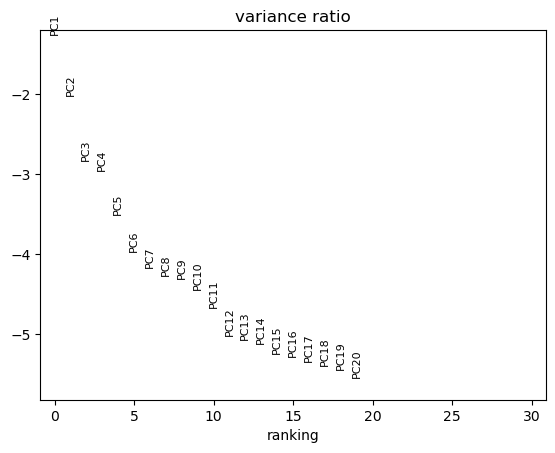

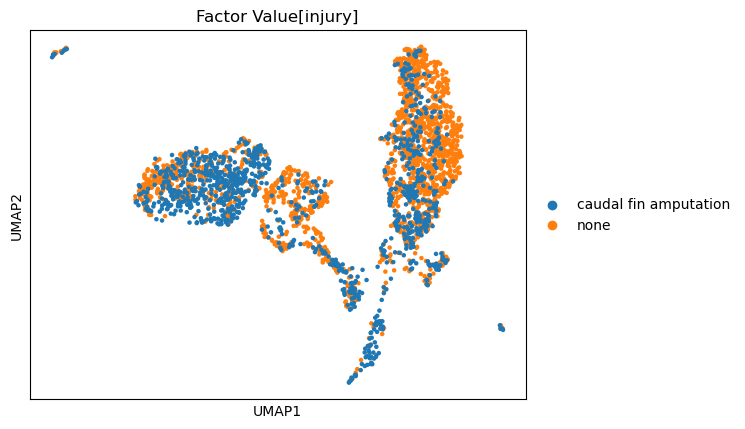

In [8]:
sc.pp.pca(dr_hvg, n_comps=N_COMPONENTS, random_state=RANDOM_STATE)
sc.pl.pca_variance_ratio(dr_hvg, log=True)
sc.pp.neighbors(dr_hvg, n_neighbors=N_EDGES, random_state=RANDOM_STATE)
sc.tl.umap(dr_hvg, random_state=RANDOM_STATE, n_components=3)
sc.pl.umap(dr_hvg, color="Factor Value[injury]")

What happens if we cluster?

In [9]:
# The graph from GmGM 
sc.tl.leiden(
    dr_hvg,
    neighbors_key='obs_neighbors_gmgm',
    key_added='leiden_gmgm',
    random_state=RANDOM_STATE
)
sc.tl.leiden(dr_hvg, neighbors_key='neighbors', key_added='leiden_knn', random_state=RANDOM_STATE)

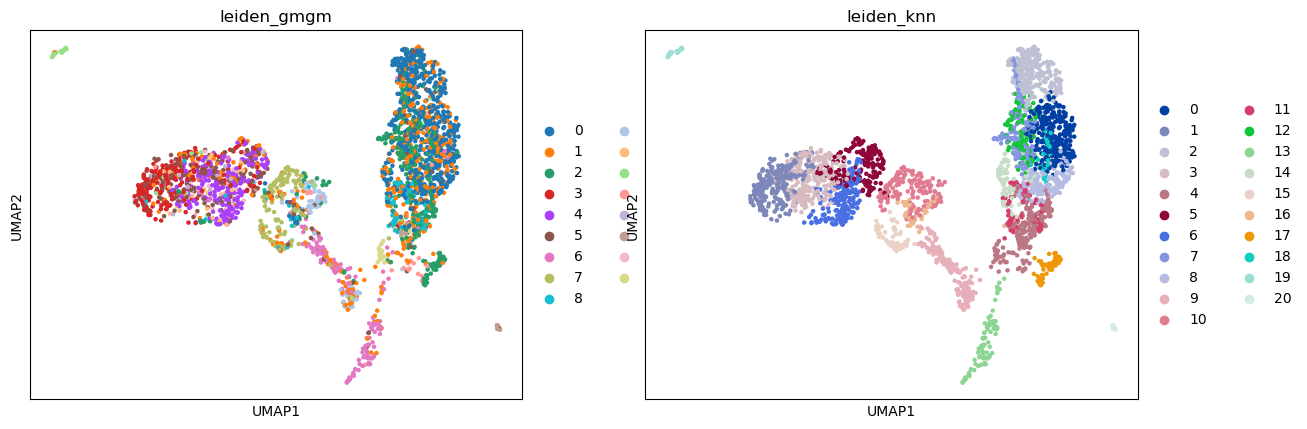

In [10]:
sc.pl.umap(
    dr_hvg,
    color=["leiden_gmgm", "leiden_knn"],
)

How much do GmGM+Leiden and KNN+Leiden agree?  Well, they agree broadly but differ on some matters.

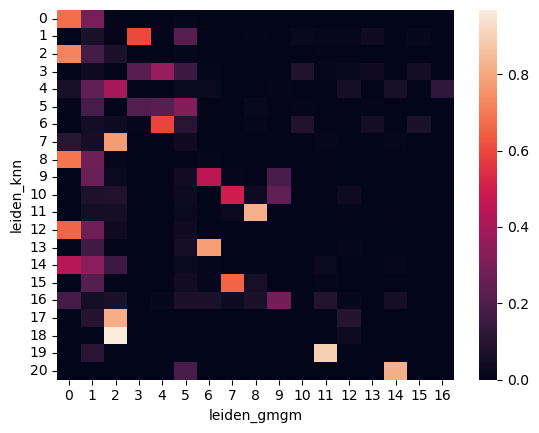

In [11]:
cmtx = sc.metrics.confusion_matrix(
    dr_hvg.obs['leiden_knn'],
    dr_hvg.obs['leiden_gmgm'],
)
sns.heatmap(cmtx, annot=False)
pass

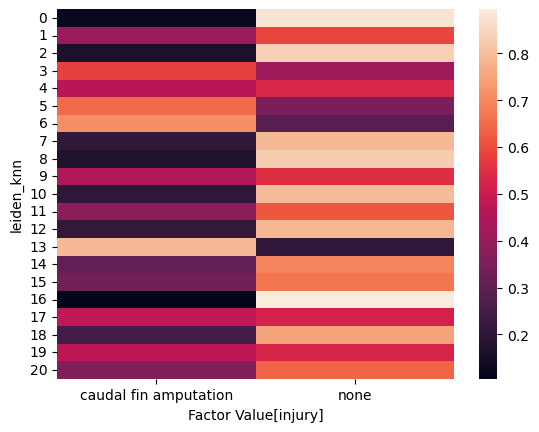

In [12]:
cmtx = sc.metrics.confusion_matrix(
    dr_hvg.obs['leiden_knn'],
    dr_hvg.obs['Factor Value[injury]'],
)
sns.heatmap(cmtx, annot=False)
pass

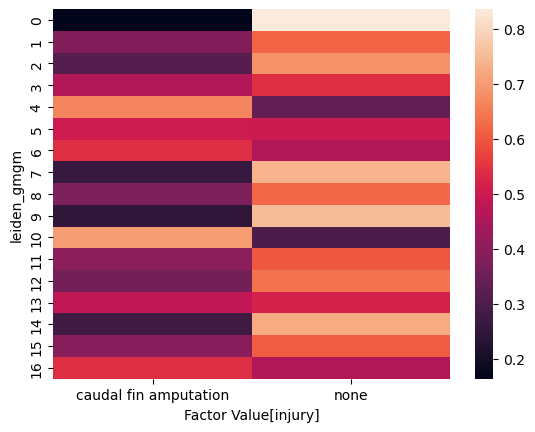

In [13]:
cmtx = sc.metrics.confusion_matrix(
    dr_hvg.obs['leiden_gmgm'],
    dr_hvg.obs['Factor Value[injury]'],
)
sns.heatmap(cmtx, annot=False)
pass

## Faster!

We can speed up computations by only selecting the top n principle components in our algorithm.  Let's see how the results compare.

In [14]:
old_dr_hvg_clusters = dr_hvg.obs['leiden_gmgm'].copy()
dr_hvg = danio_rerio_scrna[:, danio_rerio_scrna.var["highly_variable"]].copy()
dr_hvg.obs['old_leiden_gmgm'] = old_dr_hvg_clusters
GmGM(
    dr_hvg,
    centering_method="clr-prost",
    to_keep={
        "obs": N_EDGES,
        "var": N_EDGES
    },
    threshold_method="rowwise-col-weighted",
    verbose=True,
    n_comps=N_COMPONENTS,
)
sc.pp.log1p(dr_hvg)
dr_hvg

Centering...
Calculating eigenvectors...
	by calculating SVD...
Calculating eigenvalues...
@0: 915974.6457492943 (-266.47925070568357 + 916241.125 + 0) ∆inf
Converged! (@16: 480864.65572591196)
Recomposing sparse precisions...
Converting back to AnnData...


AnnData object with n_obs × n_vars = 2860 × 3000
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[strain]', 'Sample Characteristic Ontology Term[strain]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[sampling time point]', 'Sample Characteristic Ontology Term[sampling time point]', 'Sample Characteristic[genotype]', 'Sample Characteristic Ontology Term[genotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Factor Value[injury]', 'Factor Value Ontology Term[injury]', 'old_leiden_gmgm'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'obs_neighbors_gmgm', 'var_neighbo

In [15]:
sc.pp.pca(dr_hvg, n_comps=N_COMPONENTS, random_state=RANDOM_STATE)
sc.pp.neighbors(dr_hvg, n_neighbors=N_EDGES, random_state=RANDOM_STATE)
sc.tl.umap(dr_hvg, random_state=RANDOM_STATE, n_components=3)

In [16]:
# The graph from GmGM 
sc.tl.leiden(
    dr_hvg,
    neighbors_key='obs_neighbors_gmgm',
    key_added='leiden_gmgm',
    random_state=RANDOM_STATE
)
sc.tl.leiden(dr_hvg, neighbors_key='neighbors', key_added='leiden_knn', random_state=RANDOM_STATE)

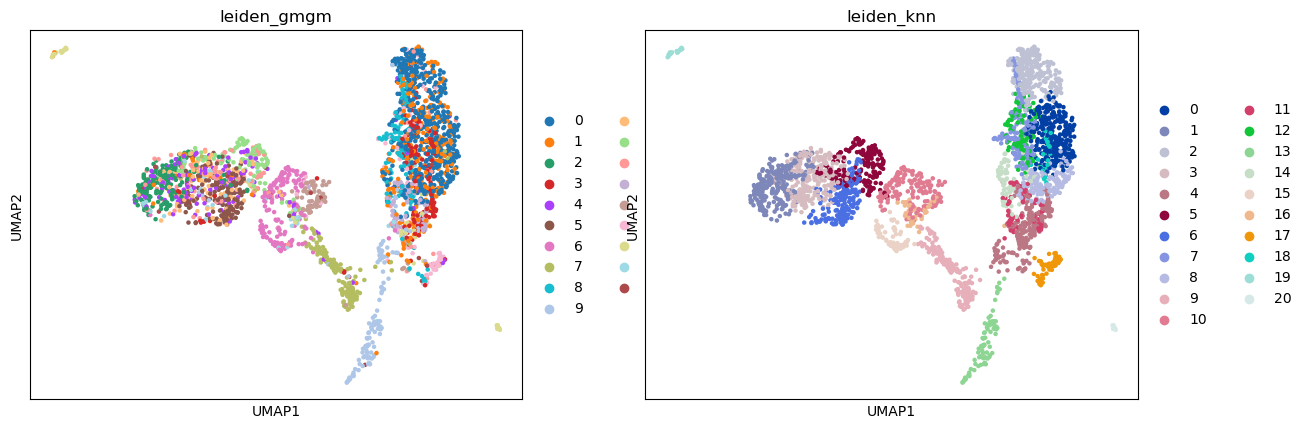

In [17]:
sc.pl.umap(
    dr_hvg,
    color=["leiden_gmgm", "leiden_knn"],
)

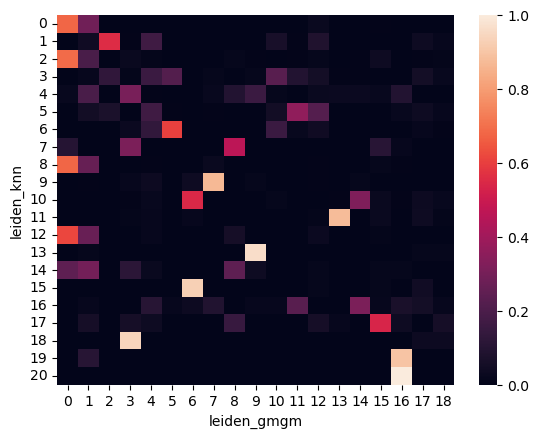

In [18]:
cmtx = sc.metrics.confusion_matrix(
    dr_hvg.obs['leiden_knn'],
    dr_hvg.obs['leiden_gmgm'],
)
sns.heatmap(cmtx, annot=False)
pass

We can see that our clusters using all components and using just 20 are somewhat similar!  To really understand how similar our graphs are, we would need some graph similarity metrics - out of scope for this example notebook.

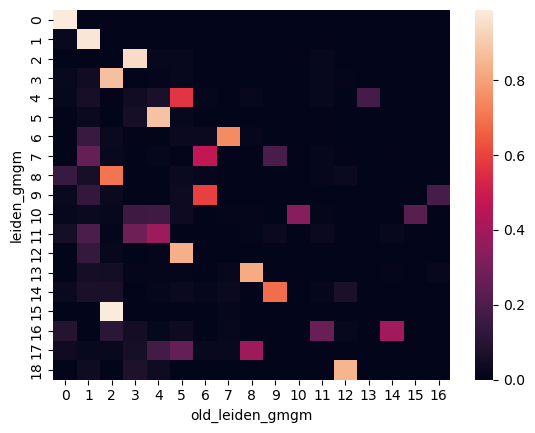

In [19]:
cmtx = sc.metrics.confusion_matrix(
    dr_hvg.obs['leiden_gmgm'],
    dr_hvg.obs['old_leiden_gmgm'],
)
sns.heatmap(cmtx, annot=False)
pass

## More complicated example

Since we already know our dataset is comprised of two separate samples (amputated and non-amputated caudal fin), it is reasonable to assume independence of the two sets of cells.  In that case, we have two datasets that share a "gene" axis, and have two separate "cell" axes.

In this section we will show how to use GmGM.  Note that its use here is analogous to its use in the multi-omics context, in which the "cell" axis is shared between a dataset with a "gene" axis and a dataset with a "peak" axis.

To do this, all that is necessary is to directly create a `Dataset` object describing the structure of our multi-modal dataset.

In [20]:
dataset = Dataset(
    dataset={
        "uncut": danio_rerio_scrna[danio_rerio_scrna.obs["Factor Value[injury]"] == "none", :].X,
        "cut":  danio_rerio_scrna[danio_rerio_scrna.obs["Factor Value[injury]"] == "caudal fin amputation", :].X
    },
    structure={
        "uncut": ("uncut_cells", "genes"),
        "cut": ("cut_cells", "genes")
    }
)
dataset

Dataset(
	uncut: ('uncut_cells', 'genes')
	cut: ('cut_cells', 'genes')
)
Axes(
	cut_cells: 1060
		Prior: None
		Gram: Not calculated
		Eig: Not calculated
	uncut_cells: 1800
		Prior: None
		Gram: Not calculated
		Eig: Not calculated
	genes: 18358
		Prior: None
		Gram: Not calculated
		Eig: Not calculated
)

This time, `GmGM` will operate directly on a dataset object.

Furthermore, suppose we don't want to limit to highly variable genes, but are rather interested in a graph of all the genes.  In this case, we have 22,070 genes.  `GmGM` by default has quadratic memory use; 22,000 is doable but takes quite a lot of memory.  We can set the `n_comps` parameter allow us to discard most eigenvector information.

In [21]:
GmGM(
    dataset,
    centering_method="clr-prost",
    to_keep={
        "uncut_cells": N_EDGES,
        "cut_cells": N_EDGES,
        "genes": N_EDGES
    },
    threshold_method="rowwise-col-weighted",
    n_comps=N_COMPONENTS,
    verbose=True
)

Centering...
Calculating eigenvectors...
	by calculating left eigenvectors of concatenated matricizations...


/Users/baileyandrew/mambaforge/envs/GmGM-python-demo/lib/python3.9/site-packages/GmGM/core/core.py:43: UserWarning: Dataset was sparse but `direct_left_eigenvectors` will desparsify it.  This will change eventually.
  warnings.warn(
/Users/baileyandrew/mambaforge/envs/GmGM-python-demo/lib/python3.9/site-packages/GmGM/core/core.py:43: UserWarning: Dataset was sparse but `direct_left_eigenvectors` will desparsify it.  This will change eventually.
  warnings.warn(
/Users/baileyandrew/mambaforge/envs/GmGM-python-demo/lib/python3.9/site-packages/GmGM/core/core.py:43: UserWarning: Dataset was sparse but `direct_left_eigenvectors` will desparsify it.  This will change eventually.
  warnings.warn(


Calculating eigenvalues...
@0: 5885669.925064739 (-544.0749352613616 + 5886214.0 + 0) ∆inf
@4: 3261452.907737646 - Line Search Gave Up!
Converged! (@4: 3193897.4754835847)
Recomposing sparse precisions...
Done!


Dataset(
	uncut: ('uncut_cells', 'genes')
	cut: ('cut_cells', 'genes')
)
Axes(
	cut_cells: 1060
		Prior: None
		Gram: Not calculated
		Eig: Calculated
	uncut_cells: 1800
		Prior: None
		Gram: Not calculated
		Eig: Calculated
	genes: 18358
		Prior: None
		Gram: Not calculated
		Eig: Calculated
)

It's hard to check if we did well, so let's make do a "UMAP consistency plot" to see if we learned anything; i.e. let's plot a UMAP of our genes and color by our gene graph.  When our algorithm fails, the clustering looks random.  If the clustering is contiguous, then we know our algorithm worked (although whether or not the clusters are meaningful or useful is a task for downstream analysis...).

In [22]:
# First we have to manually add our graph to the anndata object
dr_genes = danio_rerio_scrna.transpose()
dr_genes.uns[f'neighbors_gmgm'] = {
    'connectivities_key': f'gmgm_connectivities',
    'distances_key': f'gmgm_connectivities',
}

dr_genes.uns[f'neighbors_gmgm']['params'] = {
    'method': 'gmgm',
    'random_state': RANDOM_STATE,
}
dr_genes.obsp[f'gmgm_connectivities'] = abs(dataset.precision_matrices["genes"]).tocsr()
dr_genes

AnnData object with n_obs × n_vars = 18358 × 2860
    obs: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    var: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[strain]', 'Sample Characteristic Ontology Term[strain]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[sampling time point]', 'Sample Characteristic Ontology Term[sampling time point]', 'Sample Characteristic[genotype]', 'Sample Characteristic Ontology Term[genotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Factor Value[injury]', 'Factor Value Ontology Term[injury]'
    uns: 'hvg', 'neighbors_gmgm'
    obsp: 'gmgm_connectivities'

In [23]:
sc.tl.leiden(
    dr_genes,
    neighbors_key='neighbors_gmgm',
    key_added='leiden_gmgm',
    random_state=RANDOM_STATE,
)

In [24]:

# Depending on the parameters you choose above, there may be lots of singleton genes
# This just de-singletonizes them.
largest_nonsingleton = \
    dr_genes.obs['leiden_gmgm'].value_counts().index[(dr_genes.obs['leiden_gmgm'].value_counts() > 1)].codes.max()
dr_genes.obs['leiden_gmgm'][dr_genes.obs['leiden_gmgm'].astype(int) > largest_nonsingleton] = None
dr_genes.obs['leiden_gmgm'] = dr_genes.obs['leiden_gmgm'].cat.remove_unused_categories()
dr_genes.obs['leiden_gmgm'].value_counts()

0     10951
1      1451
2       948
3       932
4       851
5       670
6       572
7       439
8       204
9       175
10       94
11       54
12       50
13       11
14        4
Name: leiden_gmgm, dtype: int64

Note that this PCA explained variance plot gives us a chance to verify our assumption that `N_COMPONENTS` was a sufficient approximation for our dataset - it seems so!

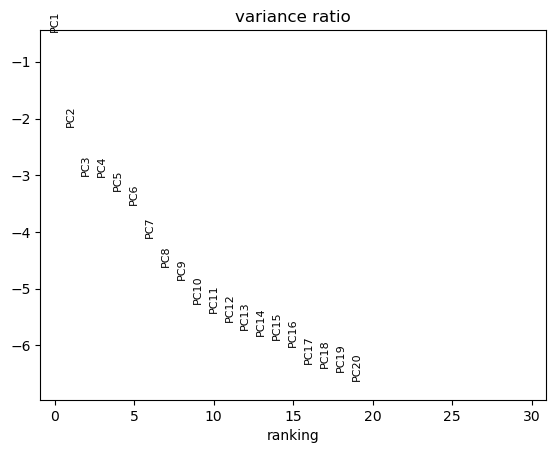

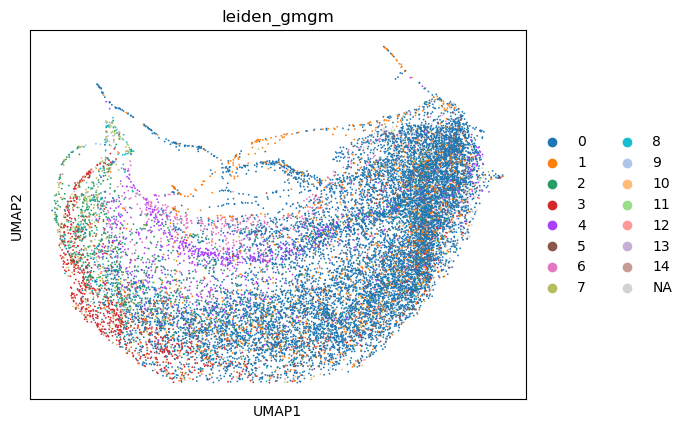

In [25]:
sc.pp.pca(dr_genes, n_comps=N_COMPONENTS, random_state=RANDOM_STATE)
sc.pl.pca_variance_ratio(dr_genes, log=True)
sc.pp.neighbors(dr_genes, n_neighbors=N_EDGES, random_state=RANDOM_STATE)
sc.tl.umap(dr_genes, random_state=RANDOM_STATE, n_components=3)
sc.pl.umap(dr_genes, color="leiden_gmgm")

It looks a bit like a mantis shrimp?  Or a slug with whiskers.  It seems we have some clusters following clear 'tentacles' along the slug, but it is hard to say much about their utility.